In [1]:
#Python == 3.8.17
#numpy == 1.24.3
#torch >= 1.11.0
#scipy == 1.10.1
#sklearn >= 0.22.1
#matplotlib == 3.7.1
#umap >= 0.5.2
#leidenalg >= 0.9.1
#pandas == 1.5.3
#adjustText >= 0.7.3 

In [2]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scipy.sparse as sp
import episcanpy
import scanpy as sc
import anndata as ad

import scmomat 

plt.rcParams["font.size"] = 10

/Users/maiia.shulman/anaconda3/envs/scmomat/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/maiia.shulman/anaconda3/envs/scmomat/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/maiia.shulman/anaconda3/envs/scmomat/lib/python

## Read the data

In [3]:
multiom = ad.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
multiom

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
multiom = multiom[multiom.obs['Site'].isin(['site1', 'site2'])].copy() #select site1 and site2 as a reference
multiom

AnnData object with n_obs × n_vars = 32469 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
atac_multiom = multiom[:, multiom.var['feature_types'] == 'ATAC'].copy()
rna_multiom = multiom[:, multiom.var['feature_types'] == 'GEX'].copy()
rna_multiom, atac_multiom

(AnnData object with n_obs × n_vars = 32469 × 13431
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
     var: 'feature_types', 'gene_id'
     uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
     obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 32469 × 116490
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist

In [6]:
assert np.sum(rna_multiom.obs_names != atac_multiom.obs_names) == 0 #we make sure that cells are the same in multiome data

In [7]:
cite = ad.read_h5ad("GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
cite

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [8]:
cite = cite[cite.obs['Site'].isin(['site1', 'site2'])].copy() #select site1 and site2 as a reference
cite

AnnData object with n_obs × n_vars = 41482 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [9]:
adt_cite = cite[:, cite.var['feature_types'] == 'ADT'].copy()
rna_cite = cite[:, cite.var['feature_types'] == 'GEX'].copy()
adt_cite, rna_cite

(AnnData object with n_obs × n_vars = 41482 × 134
     obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
     var: 'feature_types', 'gene_id'
     uns: 'dataset_id', 'genome', 'organism'
     obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 41482 × 13953
     obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot',

In [10]:
assert np.sum(rna_cite.obs_names != adt_cite.obs_names) == 0 #we make sure that cells are the same in cite data

In [11]:
def update_obs_column(
    adata, obs_column_name, suffix, how="right", new_obs_column_name=None
):
    if new_obs_column_name is None:
        new_obs_column_name = f"new_{obs_column_name}"
    # otherwise can't use + operator with categorical columns
    adata.obs[obs_column_name] = adata.obs[obs_column_name].astype("str").copy()
    # create new column in .obs
    if how == "right":
        adata.obs[new_obs_column_name] = f"_{suffix}"
        adata.obs[new_obs_column_name] = (
            adata.obs[obs_column_name] + adata.obs[new_obs_column_name]
        )
    else:
        adata.obs[new_obs_column_name] = f"{suffix}_"
        adata.obs[new_obs_column_name] = (
            adata.obs[new_obs_column_name] + adata.obs[obs_column_name]
        )
    return adata

In [12]:
rna_multiom = update_obs_column(rna_multiom, "batch", "_rna_multiome")
atac_multiom = update_obs_column(atac_multiom, "batch", "_atac_multiome")
rna_cite = update_obs_column(rna_cite, "batch", "_rna_cite")
adt_cite = update_obs_column(adt_cite,  "batch", "_adt_cite")

## Concatenate RNA

In [13]:
rna = rna_multiom.concatenate(rna_cite, batch_key='concat_key', index_unique=None)
rna

AnnData object with n_obs × n_vars = 73951 × 12059
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'new_batch', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'concat_key'
    var: 'feature_types', 'gene_id-0', 'gene_id-1'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Map ATAC peaks to genes

In [14]:
# map atac peaks to genes
atac_multiom.var.index = atac_multiom.var.index.map(lambda x: x.replace("-", ":", 1))
atac_multiom = episcanpy.tl.geneactivity(atac_multiom, gtf_file="gencode.v41.chr_patch_hapl_scaff.annotation.gtf")

In [15]:
atac_multiom = atac_multiom[:, ~atac_multiom.var.index.duplicated()]

In [16]:
#atac_multiom.write_h5ad("atac_genes.h5ad")

##  Load dataset
Make sure that the dataset get stored in a dictionary (`counts` in the script), with the item:
* `nbatches`: total number of batches
* `feats_name`: a dictionary storing the feature names for different modalities, e.g. `{"rna": np.array([aaaa, bbbb,...]), "atac": np.array([ccc, ddd, ...]), "protein": np.array([eee, fff, ...])}`
* `modality 1` (e.g. `rna` in the example below): a `list` store all data matrices correspond to modality 1, a element correspond to one batch, elements are ordered in the list following the ordering of batches. **The batches that does not have count matrix in corresponding modality is inserted `None` as placeholder**
* `modality 2` (e.g. `atac` in the example below): requirement the same as above.
* `modality 3` (e.g. `protein`): requirement the same as above.
* ...

#### Note:
* The number of item in the `feats_name` should match the number of modalities in `counts`. 
* The length of lists in `modality 1`, `modality 2`, `modality 3`, etc should have the same length, which is equal to `nbatches`. (missing matrices are denoted as `None` as explained above). **The matrices must be ordered according to the batch ID in each list,** so that scMoMaT can detact parallel sequenced batches.
* The data matrix in each modality (each list) should have the same set of features. You can do thie by 1. using the intersection of all genes/proteins in different batches; 2. Remap the chromatin regions according to the peaks of one batch. 
* The data matrix is of the shape `(ncells, nfeatures)`, and preprocessed with `utils.preprocess()` function.

One example template is shown as below, note that the features of data matrices are matched in advance. The connection matrix (`GxR.npz`) that is used to generate pseudo-count is also provided in advance (used the code in folder `calc_pseudo_count/calc_pseudo_count.R`). Feel free to modify on the template to use your dataset.


In [17]:
genes = np.array(rna.var.index.tolist())

In [18]:
regions = np.array(atac_multiom.var.index.tolist())

In [19]:
proteins = np.array(adt_cite.var.index.tolist())

In [20]:
feats_name = {"rna": genes, "atac": regions, "proteins": proteins}

In [21]:
batches_cite = list(set(adt_cite.obs.batch.unique()).union(rna[rna.obs.Modality == "cite"].obs.batch.unique()))

In [22]:
batches_multiome = list(set(atac_multiom.obs.batch.unique()).union(rna[rna.obs.Modality == "multiome"].obs.batch.unique()))

In [23]:
n_batches = len(batches_cite) + len(batches_multiome)

In [24]:
counts_atacs = []
counts_rnas = []
counts_adts = []

for batch in batches_multiome:
    # process rna
    rna_index = rna[(rna.obs.batch == batch) & (rna.obs.Modality == "multiome")].obs.index
    rna_batch = np.array(rna[rna.obs.index.isin(rna_index)].X.todense())
    if len(rna_batch) > 0:
        rna_batch = scmomat.preprocess(rna_batch, modality = "RNA", log = False)
        counts_rnas.append(rna_batch)
    else:
        counts_rnas.append(None)
    # process atac
    atac_batch = atac_multiom[atac_multiom.obs.index.isin(rna_index)].X   
    if len(atac_batch) > 0:
        atac_batch = scmomat.preprocess(atac_batch, modality = "ATAC")
        counts_atacs.append(atac_batch)
    else:
        counts_atacs.append(None)
    counts_adts.append(None)

for batch in batches_cite:
    # process rna
    rna_index = rna[(rna.obs.batch == batch) & (rna.obs.Modality == "cite")].obs.index
    rna_batch = np.array(rna[rna.obs.index.isin(rna_index)].X.todense())
    if len(rna_batch) > 0:
        rna_batch = scmomat.preprocess(rna_batch, modality = "RNA", log = False)
        counts_rnas.append(rna_batch)
    else:
        counts_rnas.append(None)
    # process adt
    adt_batch = np.array(adt_cite[adt_cite.obs.index.isin(rna_index)].X.todense())
    if len(adt_batch) > 0:
        adt_batch = scmomat.preprocess(adt_batch, modality = "protein")
        counts_adts.append(adt_batch)
    else:
        counts_adts.append(None)
    counts_atacs.append(None)

In [25]:
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs, "proteins": counts_adts}

In [26]:
num_features = atac_multiom[0].shape
num_features

(1, 31907)

## Training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 896.9611
	 loss reconstruction: 0.89546
	 loss regularization: 1.50000
Epoch 100, Validating Loss: 792.9504
	 loss reconstruction: 0.79294
	 loss regularization: 0.00552
Epoch 200, Validating Loss: 784.4417
	 loss reconstruction: 0.78426
	 loss regularization: 0.18491
Epoch 300, Validating Loss: 755.1906
	 loss reconstruction: 0.75401
	 loss regularization: 1.18458
Epoch 400, Validating Loss: 728.8849
	 loss reconstruction: 0.72861
	 loss regularization: 0.27096
Epoch 500, Validating Loss: 717.1113
	 loss reconstruction: 0.71665
	 loss regularization: 0.45717
Epoch 600, Validating Loss: 701.9874
	 loss reconstruction: 0.70153
	 loss regularization: 0.45300
Epoch 700, Validating Loss: 693.2838
	 loss reconstruction: 0.69302
	 loss regularization: 0.26489
Epoch 800, Validating Loss: 689.0240
	 loss reconstruction: 0.68875
	 loss regularization: 0.27421
Epoch 900, Validating Loss: 685.8439
	 loss reconstruction: 0.68557
	 loss regu

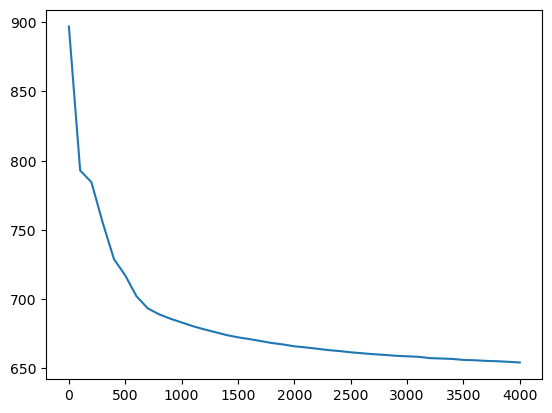

In [27]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 25
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Here we list other parameters in the function for illustration purpose, most of these parameters are set as default value.
# weight on regularization term, default value
lamb = 0.001 
# number of total iterations, default value
T = 4000
# print the result after each ``interval'' iterations, default value
interval = 100
# batch size for each iteraction, default value
batch_size = 0.1
# learning rate, default value
lr = 1e-2
# random seed, default value
seed = 0
# running device, can be CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

# Plot loss function
x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

zs = model.extract_cell_factors()
rnas_names = []

for batch in batches_multiome:
    rnas_names.extend(rna[(rna.obs.batch == batch) & (rna.obs.Modality == "multiome")].obs.index.tolist())
for batch in batches_cite:
    rnas_names.extend(rna[(rna.obs.batch == batch) & (rna.obs.Modality == "cite")].obs.index.tolist())

pd.DataFrame(np.concatenate(zs, axis=0), index=rnas_names).to_csv("momat_integrated.csv")